In [1]:
import skeliner as sk
import numpy as np

# Post-processing

In [2]:
name = 720575940573924400
mesh = sk.io.load_mesh(f"../dev/temp_io/{name}.ctm")
skel = sk.io.load_npz(f"../dev/temp_io/{name}.npz")

## Fixing dendritic loops

Automatic skeletonization is only as good as the underlying mesh. We often need to apply post-processing to correct obvious errors.

In the example below, one edge between the soma and a primary dendrite is missing.

(<Figure size 800x800 with 3 Axes>,
 {'B': <Axes: label='B', ylabel='z (μm)'>,
  'A': <Axes: label='A', xlabel='x (μm)', ylabel='y (μm)'>,
  'C': <Axes: label='C', xlabel='z (μm)'>})

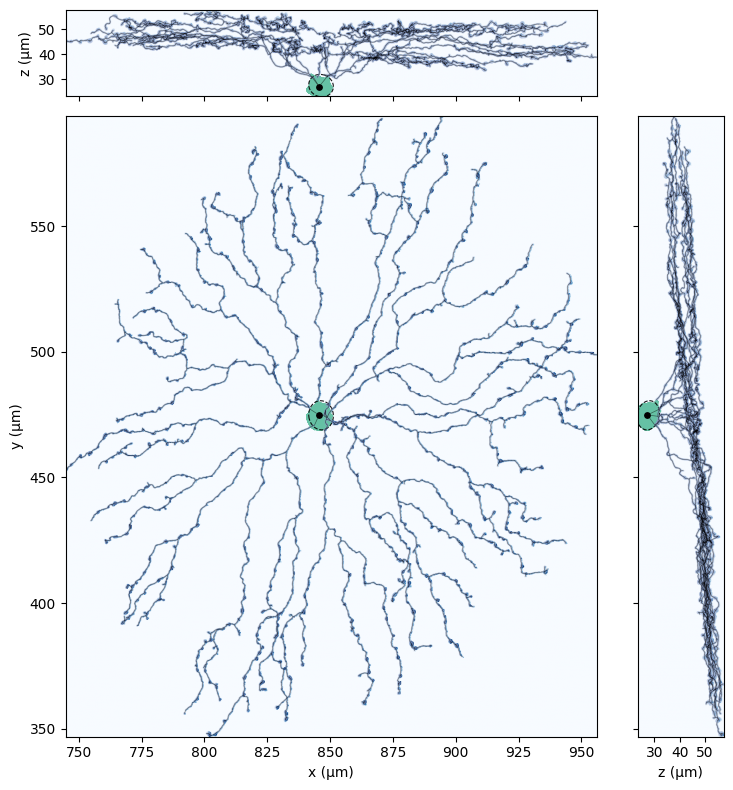

In [3]:
sk.plot.threeviews(skel, mesh, scale=1e-3, unit="μm", color_by="ntype", skel_cmap="Set2")

This problem occurs because a fusion node joins two primary dendritic trees: if the trees are connected in the mesh, they are treated as one tree, and the error must be fixed manually.

You can call `skeliner.dx.suspicious_tips(skel)` (or the convenience method `skel.suspicious_tips()`) to find tips that are close to the soma but not connected to it.

In [4]:
suspicious_tips = skel.suspicious_tips(near_factor=1.3, path_ratio_thresh=5, return_stats=True)
suspicious_tips

([np.int64(751)],
 {751: {'d_center': 7055.417684838708,
   'd_surface': 1310.6641582598993,
   'path_len': 260628.30551563308,
   'ratio': 36.94016671411159}})

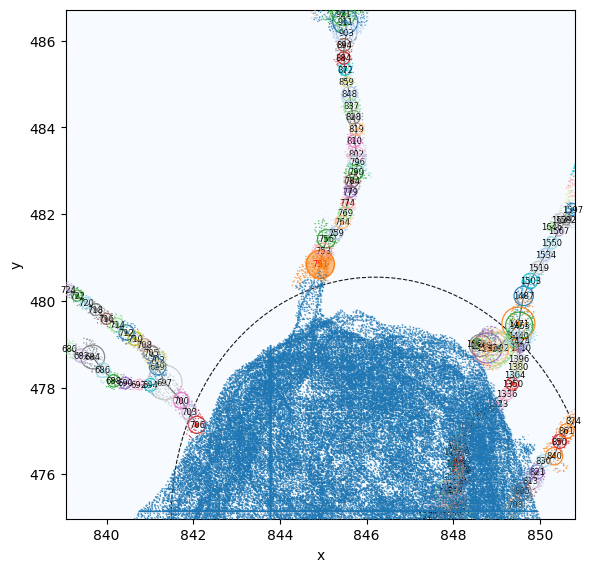

In [5]:
for node_id in suspicious_tips[0]:
    sk.plot.node_details(skel, mesh, 
                    node_id=node_id, multiplier=1,
                    scale=1e-3, 
                    draw_nodes=True, draw_edges=True,
                    show_node_ids=True,)

If you are certain that a suspicious tip should connect directly to the soma, run `skeliner.post.graft(skel, 0, n)``skel.graft(0, n)` to connect the two nodes, where `0` is always the soma ID and `n` is the tip node ID.

In [6]:
sk.post.graft(skel, 0, 751)

After grafting, the skeleton will no longer be acyclic.

In [7]:
skel.acyclicity()

False

Next we need to break the resulting loop. Visually inspect the mesh in Neuroglancer, determine the extent of the fusion point, and then use `skeliner.plot.details()` to look up the corresponding node IDs.

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

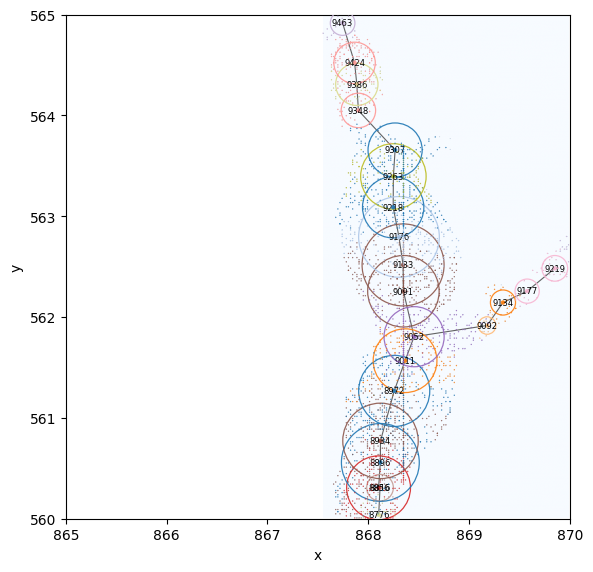

In [8]:
sk.plot.details(
    skel, mesh, 
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    show_node_ids=True,
    xlim=(865, 870),
    ylim=(560, 565),
)

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

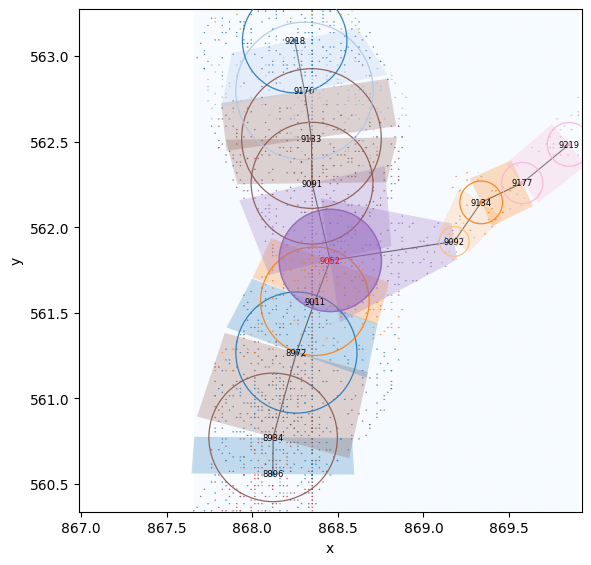

In [9]:
sk.plot.node_details(
    skel, mesh, 
    node_id=9052, multiplier=0.25,
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    draw_cylinders=True, show_node_ids=True,
)

In [10]:
# another way to print the neighbors of a node
skel.node_summary(9052)

{'degree': 3,
 'radius': 366.99081077116824,
 'neighbors': [{'id': 9011, 'degree': 2, 'radius': 389.1859671333755},
  {'id': 9091, 'degree': 2, 'radius': 436.4625304124721},
  {'id': 9092, 'degree': 2, 'radius': 106.73198739749252}]}

After comparing the skeleton with the mesh, it is preferable not to simply cut the edge between nodes 9052 and 9092. A better fix is to connect nodes 9091 and 9092 and then remove their edges to node 9052.

In [11]:
skel.graft(9011, 9091) 
skel.acyclicity()

False

In [12]:
skel.clip(9011, 9052)
skel.clip(9052, 9091)
skel.acyclicity()

True

After these steps the skeleton becomes acyclic again (that is, it no longer contains any loops).

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

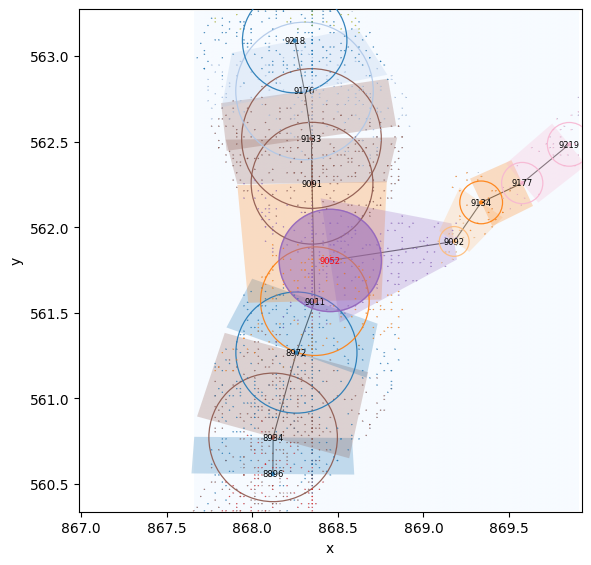

In [13]:
sk.plot.node_details(
    skel, mesh, 
    node_id=9052, multiplier=0.25,
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    draw_cylinders=True,
    show_node_ids=True,

)

(<Figure size 800x800 with 3 Axes>,
 {'B': <Axes: label='B', ylabel='z (μm)'>,
  'A': <Axes: label='A', xlabel='x (μm)', ylabel='y (μm)'>,
  'C': <Axes: label='C', xlabel='z (μm)'>})

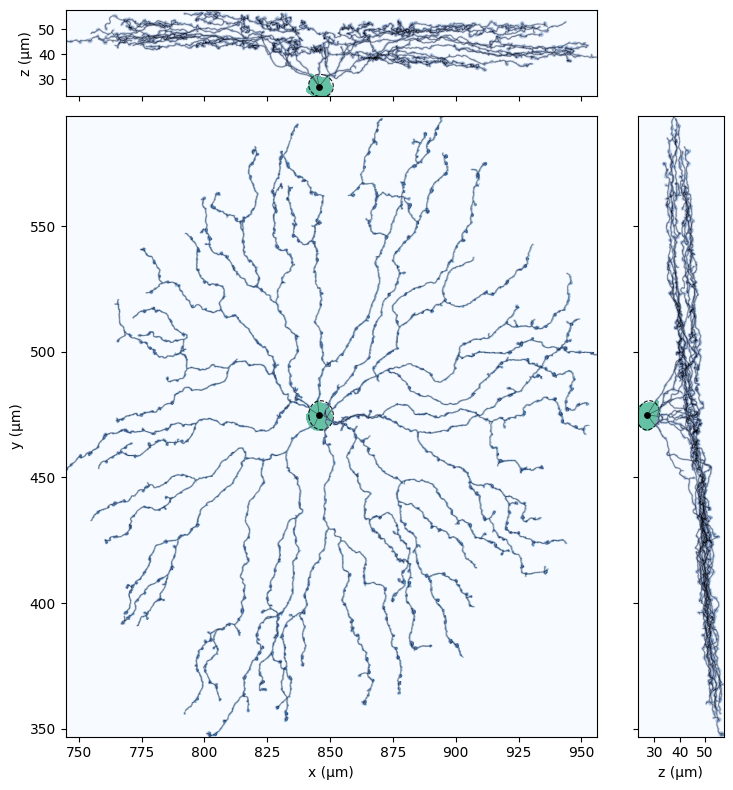

In [14]:
sk.plot.threeviews(skel, mesh, scale=1e-3, unit="μm", color_by="ntype", skel_cmap="Set2")

## Pruning "artefacts"

Because we work with high-resolution data and strive to preserve as much detail as possible, the pipeline often produces small artefact branches. These appear as tiny neurites emerging from bulb-like swellings on the dendrites. We keep them to capture the bulbs’ full geometry, but they are not genuine branches and can inflate morphological statistics such as terminal and branch-point counts.

The most common feature of these artefact branches is that they are extremely short. During skeletonization we already discard single-node branches, but we keep any branch with more than two nodes: sometimes real neurites are that short, and sometimes we need the artefact neurites to estimate bulb size.

In [15]:
short_neurites = skel.twigs_of_length(2, include_branching_node=True)
len(short_neurites)

149

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

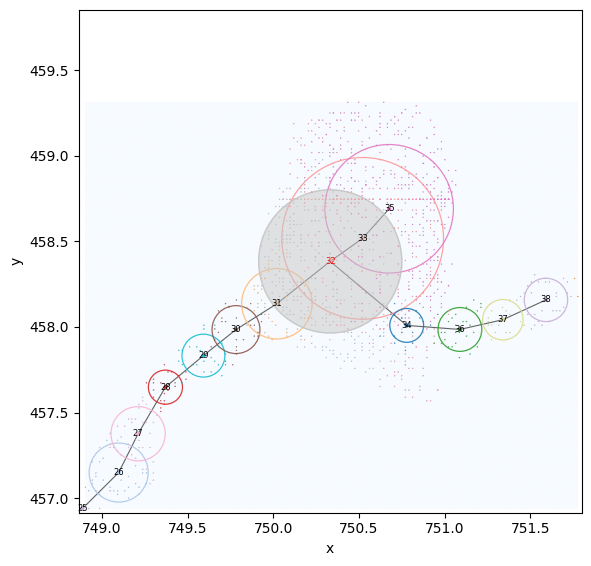

In [16]:
# an example of a short neurite capturing the bulb shape
nid = short_neurites[0][0]
sk.plot.node_details(
    skel, mesh, 
    node_id=nid, multiplier=0.25,
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    show_node_ids=True,
)

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

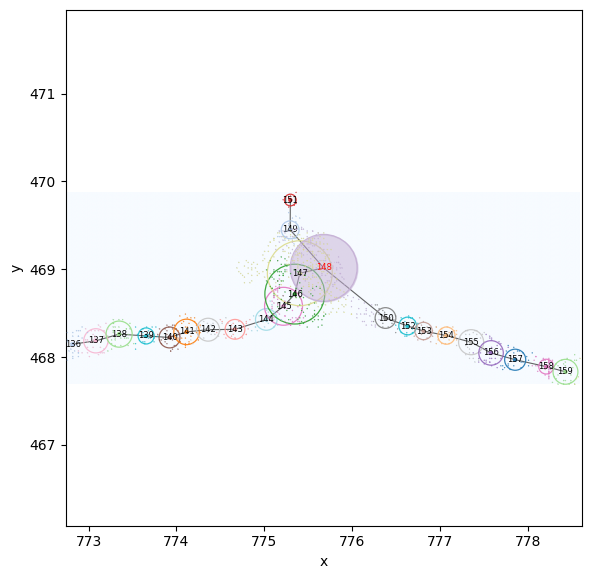

In [17]:
# an example of a real neurite at the bulb
nid = short_neurites[3][0]
sk.plot.node_details(
    skel, mesh, 
    node_id=nid, multiplier=0.5,
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    show_node_ids=True,
)

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

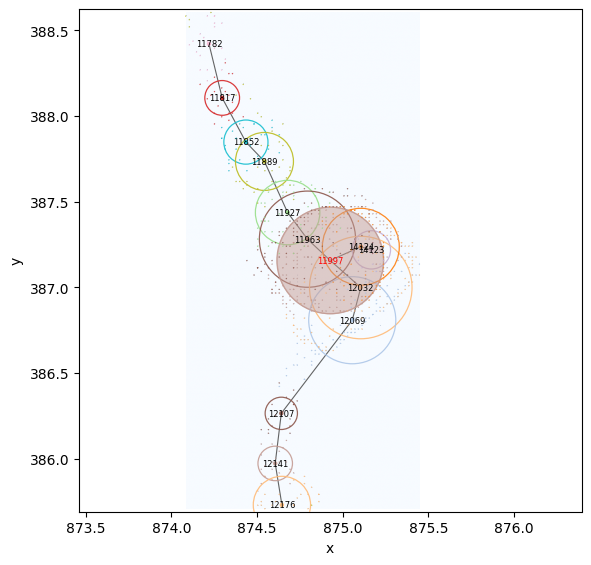

In [18]:
# an example of likely unnecesary short neurite
# but still conributes to the bulb shape
nid = short_neurites[140][0]
sk.plot.node_details(
    skel, mesh, 
    node_id=nid, multiplier=0.25,
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    show_node_ids=True,
)

Ultimately it is up to you to decide what to keep or prune. If you choose to remove these small neurites, call `skeliner.post.prune(num_node)` or simply `skel.prune(num_node)`, where `num_node` is the maximum branch length (in nodes) you want to discard.

In [19]:
skel.prune(num_nodes=2)

In [20]:
# now the short neurites are all gone
short_neurites = skel.twigs_of_length(2, include_branching_node=True)
len(short_neurites)

0

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

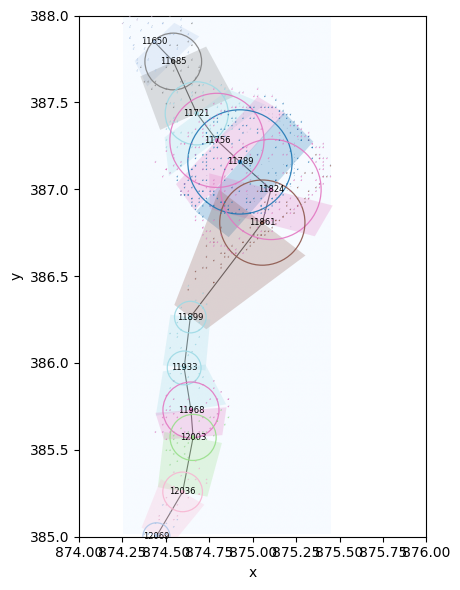

In [21]:
sk.plot.details(
    skel, mesh, 
    scale=1e-3, 
    draw_nodes=True, draw_edges=True,
    show_node_ids=True, draw_cylinders=True,
    xlim=(874, 876),
    ylim=(385, 388),
)

## Labeling different neurite types

In [22]:
name = 720575940550605504
skel = sk.io.load_swc(f"../dev/temp_io/{name}.swc")

Here we picked a cell with a very long protrusion that potentially is an axon. Every nodes except the soma will be labeled as dendrites by default straight out of `skeliner.skeletonize()`. Other neurite types have to be manually identified and set individually. We have diagnostics and post-processing tools to help you with that.

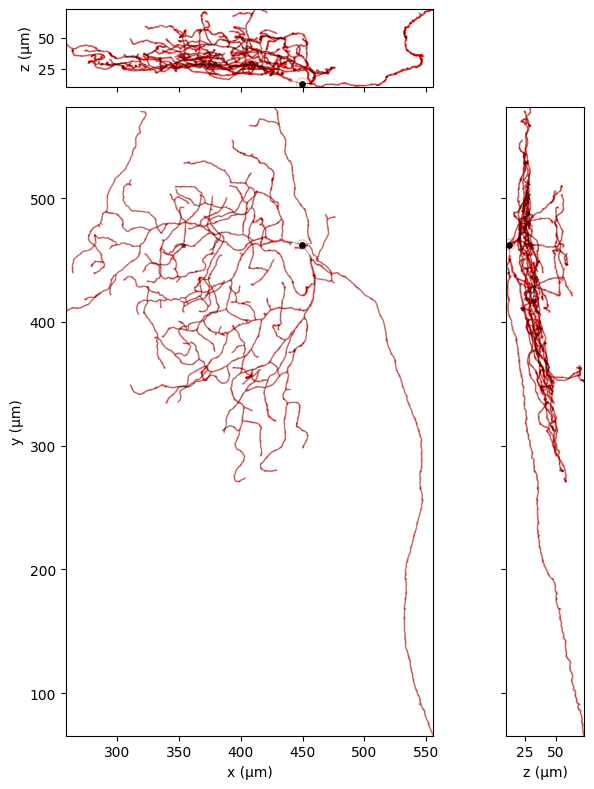

In [23]:
fig, ax = sk.plot.threeviews(skel, scale=1, unit="μm")

As before, you might want to zoom into the soma to find the connected nodes first.

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

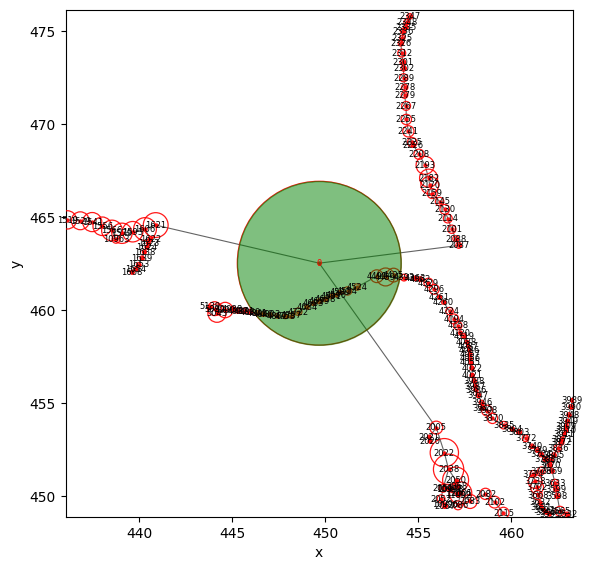

In [24]:
sk.plot.node_details(skel, node_id=0, multiplier=2.5, 
draw_edges=True, show_node_ids=True)

Then zoom into the likely branching point of the axon.

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x (μm)', ylabel='y (μm)'>)

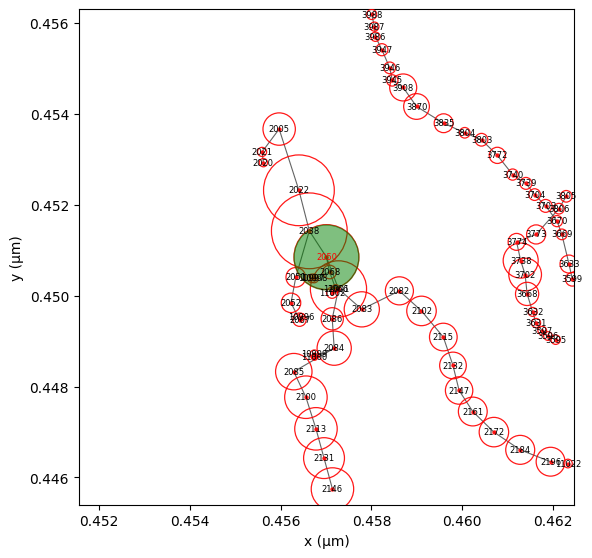

In [25]:
sk.plot.node_details(skel, node_id=2050, multiplier=1, 
draw_edges=True, show_node_ids=True, scale=1e-3, unit="μm")

The neurite starting from node 2082 is likely the axon. But you might want to confirm it first.

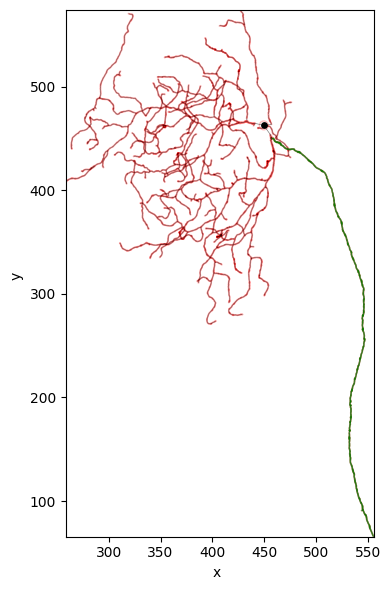

In [26]:
axon_maybe = skel.extract_neurites(root=2083)
fig, ax = sk.plot2d(skel, highlight_nodes=axon_maybe)


It looks ok. So we can the set the neurite type:

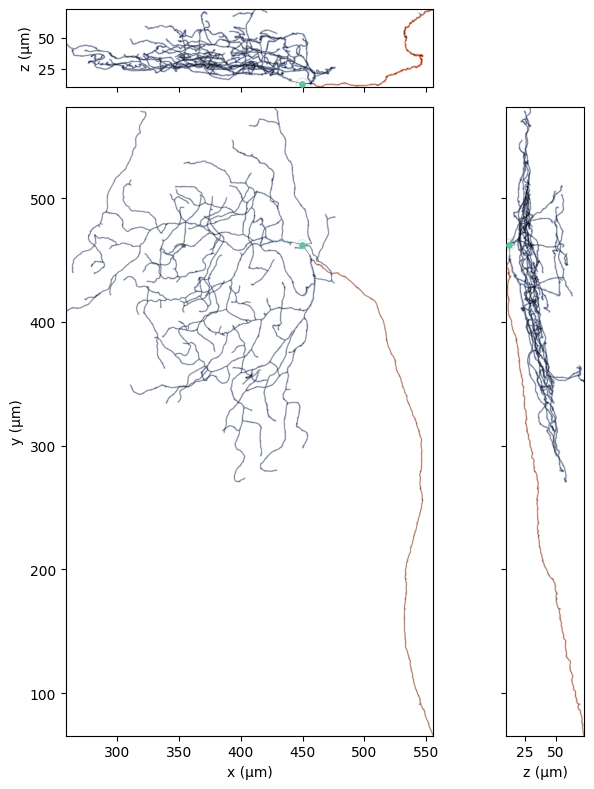

In [27]:
skel.set_ntype(root=2083, code=2) # 2=axon
fig, ax = sk.plot3v(skel, color_by='ntype', skel_cmap='Set2', scale=1, unit='μm')

## Triming Out-of-bound Neurites

In some cases, you may want to trim a neurite because it exceeds the bounds you'd like to focus on. 

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x (μm)', ylabel='y (μm)'>)

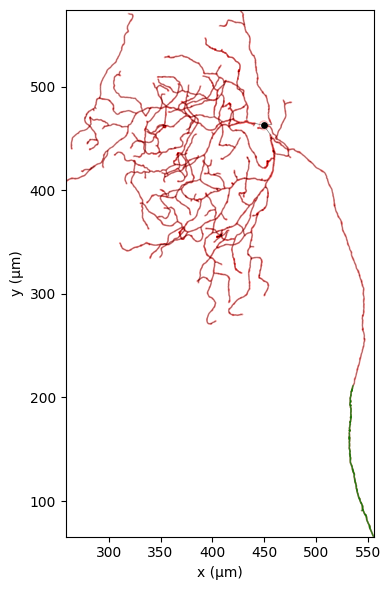

In [28]:

nids_out_of_bounds = skel.neurites_out_of_bounds(
    bounds=(1e-3 * np.array([ 65134.36889648, 211517.74597168, -100e3]), 1e-3 * np.array([1095134.36889648, 1111517.74597168,   1000e3]))
) # the bounds are still in nm because the node is in nm
sk.plot.projection(skel, scale=1, unit='μm', draw_edges=True, highlight_nodes=nids_out_of_bounds)

With that confirmed, you can prune the neurites with `prune(kind="nodes", nodes=node_ids)`:

(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='x (μm)', ylabel='y (μm)'>)

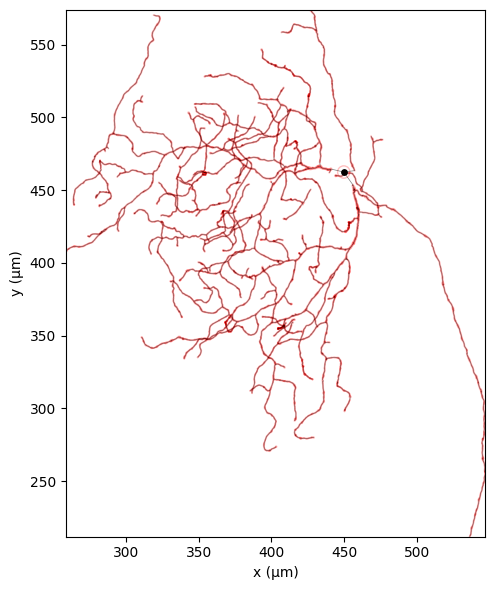

In [29]:
skel.prune(kind="nodes", nodes=nids_out_of_bounds)
sk.plot.projection(skel, scale=1, unit='μm', draw_edges=True)

##

In [30]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-06-12 18:26:54CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

numpy   : 2.0.2
skeliner: 0.1.3

Watermark: 2.5.0

